<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/Optimizer_Susceptibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents of this notebook are referred from here: https://adversarial-ml-tutorial.org/introduction/.

## Setup

In [ ]:
!pip install wandb -qq

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Utils

In [5]:
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

In [6]:
def preprocess_image(image_pixels):
    image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

## Pretrained network and an image to play with

In [7]:
# Load ResNet50
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")
resnet50.trainable = False

102973440/102967424 [==============================] - 1s 0us/step


In [8]:
!wget https://adversarial-ml-tutorial.org/introduction/pig.jpg

--2020-08-23 12:38:09--  https://adversarial-ml-tutorial.org/introduction/pig.jpg
Resolving adversarial-ml-tutorial.org (adversarial-ml-tutorial.org)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to adversarial-ml-tutorial.org (adversarial-ml-tutorial.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56267 (55K) [image/jpeg]
Saving to: ‘pig.jpg’

pig.jpg             100%[===================>]  54.95K  --.-KB/s    in 0.01s   

2020-08-23 12:38:09 (5.21 MB/s) - ‘pig.jpg’ saved [56267/56267]



## Regular inference with a pre-trained image classifier

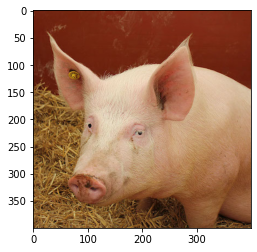

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.00031595054), ('n03935335', 'piggy_bank', 9.8273524e-08)]


In [9]:
# Preprocess the image
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)

# Run inference
original_preds = resnet50.predict(preprocessed_image)
preds_decoded = decode_predictions(original_preds, top=3)[0]
print('Predicted:', preds_decoded)

## Utils for generating a perturbed image for simple attacks

In [10]:
def preprocess_image_without(image_pixels):
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

In [11]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [12]:
def generate_adversary(iterations, source_image, delta, true_class_idx, optimizer):
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()

    for t in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(source_image + delta)
            predictions = resnet50(inp, training=False)
            loss = - scc_loss(
                    tf.convert_to_tensor([true_class_idx]),
                    predictions
                )
        if t % 5 == 0:
            print(t, loss.numpy())
    
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

        # Log to wandb
        wandb.log({'loss': loss.numpy()})
        wandb.log({'delta': wandb.Image(50*delta.numpy().squeeze()+0.5)})
        wandb.log({'perturbed_image': 
                   wandb.Image((source_image + delta).numpy().squeeze()/255)})

    return delta

In [13]:
def log_final_results_wandb(sample_image, original_predicted_label, perturbed_image,
                            adv_predicted_label, delta):
    plt.figure(figsize=(14, 14))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image)
    plt.title(f'Original Image predicted as: \n{original_predicted_label}')
    plt.subplot(1, 3, 2)
    plt.imshow(perturbed_image)
    plt.title(f'Perturbed Image predicted as: \n{adv_predicted_label}')
    plt.subplot(1, 3, 3)
    plt.imshow(delta)
    plt.title('delta')
    plt.savefig('results.png', bbox_inches='tight', pad_inches=0)
    wandb.log({'final_results': wandb.Image('results.png')})

In [14]:
def prepare_image(img_path):
    # Load and preprocess image but a but without any `preprocess_input`
    preprocessed_image = preprocess_image_without(plt.imread(img_path))

    # Convert the source image to a TensorFlow tensor and initialize
    # delta
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    return image_tensor, delta

## Simple attacks

### Adam

In [15]:
# Generate a perturbed image
wandb.init(entity='authors', project='adv-dl', id='simple-attack-adam-1')
image_tensor, delta = prepare_image('pig.jpg')
delta_optimized = generate_adversary(50, image_tensor, delta, 341, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

0 -0.00041106835
5 -0.0010640918
10 -0.0053312276
15 -0.063295044
20 -0.7706279
25 -3.4462473
30 -7.4165425
35 -13.191995
40 -16.118185
45 -16.11819


In [16]:
# Parse the predictions
original_predicted_label = decode_predictions(original_preds, top=3)[0][0][1]
adv_preds = resnet50.predict(preprocess_input(image_tensor + delta_optimized))
adv_predicted_label = decode_predictions(adv_preds, top=3)[0][0][1]

print("Original image predicted as ",original_predicted_label)
print("Perturbed image predicted as ",adv_predicted_label)

Original image predicted as  hog
Perturbed image predicted as  wombat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


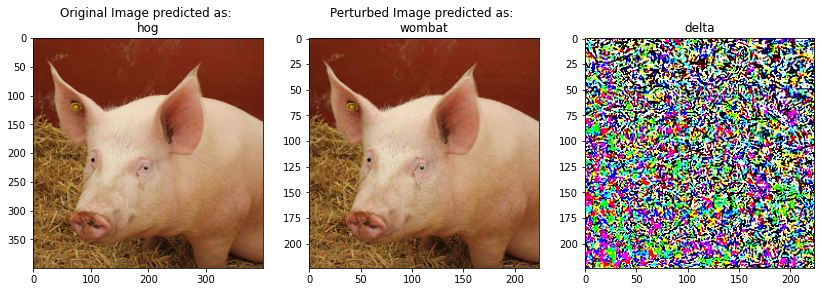

In [17]:
log_final_results_wandb(sample_image, 
    original_predicted_label, 
    (image_tensor + delta_optimized).numpy().squeeze()/255,
    adv_predicted_label, 
    50*delta_optimized.numpy().squeeze()+0.5
)

### SGD

In [18]:
# Generate a perturbed image with SGD
wandb.init(entity='authors', project='adv-dl', id='simple-attack-sgd-1')
image_tensor, delta = prepare_image('pig.jpg')
delta_optimized = generate_adversary(50, image_tensor, delta, 341, 
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1))

0 -0.00041083002
5 -0.00041083002
10 -0.0004111875
15 -0.00041523893
20 -0.0005276003
25 -0.00094166753
30 -0.001639571
35 -0.0026711281
40 -0.0040737744
45 -0.0059438376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image predicted as  hog
Perturbed image predicted as  hog


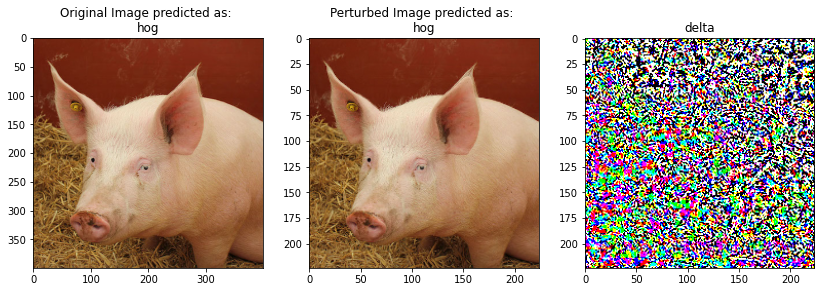

In [19]:
# Parse the predictions
original_predicted_label = decode_predictions(original_preds, top=3)[0][0][1]
adv_preds = resnet50.predict(preprocess_input(image_tensor + delta_optimized))
adv_predicted_label = decode_predictions(adv_preds, top=3)[0][0][1]

print("Original image predicted as ",original_predicted_label)
print("Perturbed image predicted as ",adv_predicted_label)

log_final_results_wandb(sample_image, 
    original_predicted_label, 
    (image_tensor + delta_optimized).numpy().squeeze()/255,
    adv_predicted_label, 
    50*delta_optimized.numpy().squeeze()+0.5
)

### RMSProp

In [20]:
# Generate a perturbed image with SGD
wandb.init(entity='authors', project='adv-dl', id='simple-attack-rmsprop-1')
image_tensor, delta = prepare_image('pig.jpg')
delta_optimized = generate_adversary(50, image_tensor, delta, 341, 
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1))

0 -0.00041094917
5 -1.4766847
10 -14.697173
15 -16.11819
20 -16.11819
25 -16.118193
30 -16.118193
35 -16.11819
40 -16.11819
45 -16.11819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image predicted as  hog
Perturbed image predicted as  wombat


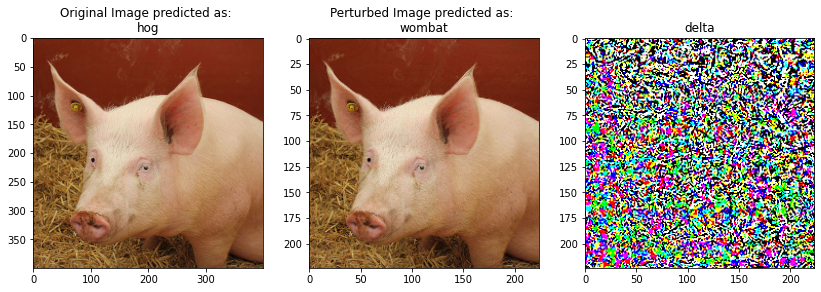

In [21]:
# Parse the predictions
original_predicted_label = decode_predictions(original_preds, top=3)[0][0][1]
adv_preds = resnet50.predict(preprocess_input(image_tensor + delta_optimized))
adv_predicted_label = decode_predictions(adv_preds, top=3)[0][0][1]

print("Original image predicted as ",original_predicted_label)
print("Perturbed image predicted as ",adv_predicted_label)

log_final_results_wandb(sample_image, 
    original_predicted_label, 
    (image_tensor + delta_optimized).numpy().squeeze()/255,
    adv_predicted_label, 
    50*delta_optimized.numpy().squeeze()+0.5
)

### Adagrad

In [22]:
# Generate a perturbed image with SGD
wandb.init(entity='authors', project='adv-dl', id='simple-attack-adagrad-1')
image_tensor, delta = prepare_image('pig.jpg')
delta_optimized = generate_adversary(50, image_tensor, delta, 341, 
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

0 -0.00041106835
5 -0.00041106835
10 -0.00041130665
15 -0.00042512917
20 -0.00063566025
25 -0.0011374439
30 -0.001946818
35 -0.0030898945
40 -0.0046421853
45 -0.0066748513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image predicted as  hog
Perturbed image predicted as  hog


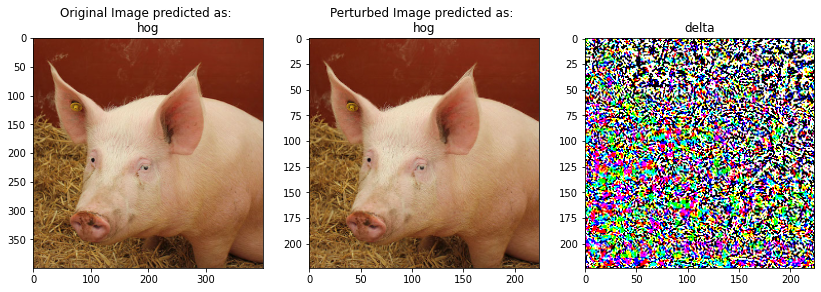

In [23]:
# Parse the predictions
original_predicted_label = decode_predictions(original_preds, top=3)[0][0][1]
adv_preds = resnet50.predict(preprocess_input(image_tensor + delta_optimized))
adv_predicted_label = decode_predictions(adv_preds, top=3)[0][0][1]

print("Original image predicted as ",original_predicted_label)
print("Perturbed image predicted as ",adv_predicted_label)

log_final_results_wandb(sample_image, 
    original_predicted_label, 
    (image_tensor + delta_optimized).numpy().squeeze()/255,
    adv_predicted_label, 
    50*delta_optimized.numpy().squeeze()+0.5
)

### FTRL

In [24]:
# Generate a perturbed image with SGD
wandb.init(entity='authors', project='adv-dl', id='simple-attack-ftrl-1')
image_tensor, delta = prepare_image('pig.jpg')
delta_optimized = generate_adversary(50, image_tensor, delta, 341, 
    optimizer=tf.keras.optimizers.Ftrl(learning_rate=0.1))

0 -0.00041106835
5 -0.00041106835
10 -0.00041094917
15 -0.00041083002
20 -0.00041106835
25 -0.00041083002
30 -0.00041083002
35 -0.00041083002
40 -0.00041106835
45 -0.00041094917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image predicted as  hog
Perturbed image predicted as  hog


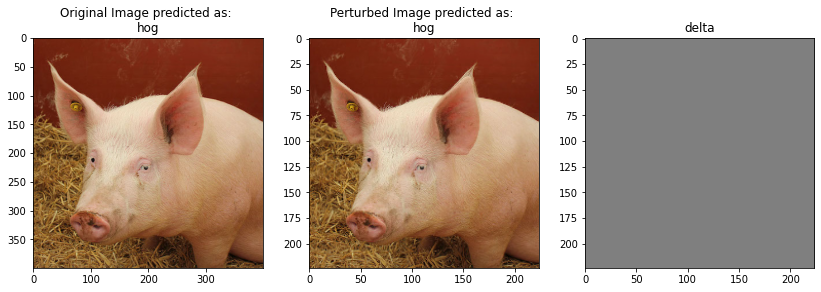

In [25]:
# Parse the predictions
original_predicted_label = decode_predictions(original_preds, top=3)[0][0][1]
adv_preds = resnet50.predict(preprocess_input(image_tensor + delta_optimized))
adv_predicted_label = decode_predictions(adv_preds, top=3)[0][0][1]

print("Original image predicted as ",original_predicted_label)
print("Perturbed image predicted as ",adv_predicted_label)

log_final_results_wandb(sample_image, 
    original_predicted_label, 
    (image_tensor + delta_optimized).numpy().squeeze()/255,
    adv_predicted_label, 
    50*delta_optimized.numpy().squeeze()+0.5
)